In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from coordination_numbers_calculation.utilities import cubic_harmonic, hanging_line
from matplotlib import cm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [2]:
# load the data
df = pd.read_csv("data/experimental_data_with_gcn_features.csv")

In [3]:
# Laod the oriented correctly Micheal data 
df_100 = df[df["normal_miller_index"]==100]
df_111 = df[df["normal_miller_index"]==111]
df_110 = df[df["normal_miller_index"]==110]

In [4]:
# get the normalized miller for the 100 data
norm_miller_indices_100 = np.concatenate([df_100[df_100["molecule"]=="D-TA"]["h"].values.reshape(-1,1), 
df_100[df_100["molecule"]=="D-TA"]["k"].values.reshape(-1,1), 
df_100[df_100["molecule"]=="D-TA"]["l"].values.reshape(-1,1)], axis= 1)
xy_100_p = df_100[df_100["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [5]:
# get the normalized miller for the 111 data
norm_miller_indices_111 = np.concatenate([df_111[df_111["molecule"]=="D-TA"]["h"].values.reshape(-1,1), 
df_111[df_111["molecule"]=="D-TA"]["k"].values.reshape(-1,1), 
df_111[df_111["molecule"]=="D-TA"]["l"].values.reshape(-1,1)], axis= 1)
xy_111_p = df_111[df_111["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [6]:
# get the normalized miller for the 110 data
norm_miller_indices_110 = np.concatenate([df_110[df_110["molecule"]=="D-TA"]["h"].values.reshape(-1,1), 
df_110[df_110["molecule"]=="D-TA"]["k"].values.reshape(-1,1),
df_110[df_110["molecule"]=="D-TA"]["l"].values.reshape(-1,1)], axis =1)
xy_110_p = df_110[df_110["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [7]:
# get the labels (D-TA half-time - L-TA half-time)
labels_100 = df_100[df_100["molecule"]=="D-TA"]["halftime(s)"].values.reshape(-1,1)- df_100[df_100["molecule"]=="L-TA"]["halftime(s)"].values.reshape(-1,1)
labels_110 = df_110[df_110["molecule"]=="D-TA"]["halftime(s)"].values.reshape(-1,1)- df_110[df_110["molecule"]=="L-TA"]["halftime(s)"].values.reshape(-1,1)
labels_111 = df_111[df_111["molecule"]=="D-TA"]["halftime(s)"].values.reshape(-1,1)- df_111[df_111["molecule"]=="L-TA"]["halftime(s)"].values.reshape(-1,1)

In [8]:
x_p_111 = norm_miller_indices_111[:,1]*np.sqrt(2/(1+norm_miller_indices_111[:,0]))
y_p_111 = norm_miller_indices_111[:,2]*np.sqrt(2/(1+norm_miller_indices_111[:,0]))
##
x_p_110 = norm_miller_indices_110[:,1]*np.sqrt(2/(1+norm_miller_indices_110[:,0]))
y_p_110 = norm_miller_indices_110[:,2]*np.sqrt(2/(1+norm_miller_indices_110[:,0]))
##
x_p_100 = norm_miller_indices_100[:,1]*np.sqrt(2/(1+norm_miller_indices_100[:,0]))
y_p_100 = norm_miller_indices_100[:,2]*np.sqrt(2/(1+norm_miller_indices_100[:,0]))

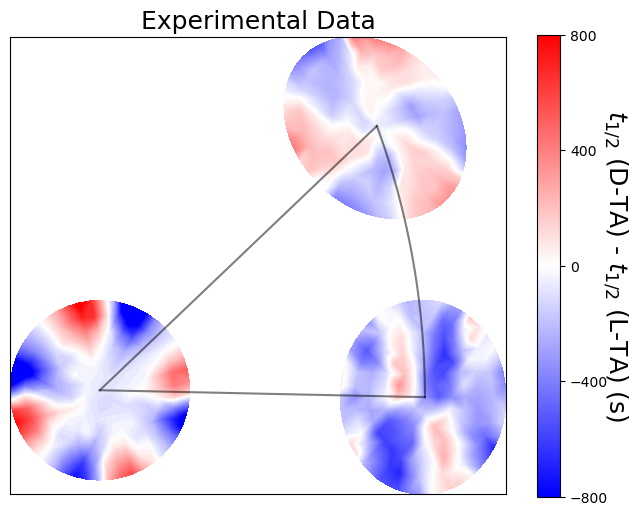

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(x_p_100, y_p_100,labels_100.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(x_p_110, y_p_110,labels_110.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(x_p_111, y_p_111,labels_111.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-800, 800, 5))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)

#Draw the stereograhic triangle
x_values_1 = x_p_100[0], x_p_110[0]	
y_values_1 =  y_p_100[0], y_p_110[0]
plt.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = x_p_100[0], x_p_111[0]	
y_values_2 =  y_p_100[0], y_p_111[0]	
plt.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [x_p_111[0],  y_p_111[0]]
point2 = [y_p_110[0], x_p_110[0]]
y_1,x_1 = hanging_line(point1, point2)
plt.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)

ax.set_title("Experimental Data", fontsize = 18)

plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

In [10]:
combined_norm_miller_idx = np.concatenate([norm_miller_indices_100, norm_miller_indices_111,norm_miller_indices_110 ], axis =0)
combined_labels = np.concatenate((labels_100, labels_111, labels_110 ), axis = 0) 

In [11]:
def combined_harmonics(norm_miller_idx):
    """function that takes in a set of miller indices and returns a set of cubic harmonics values for each miller index"""
    cubic_harm_features = []

    for i in [9,15,13,17,19,21,23,25,27,29]:
        j = cubic_harmonic(norm_miller_idx[:,0], norm_miller_idx[:,1], norm_miller_idx[:,2], i)
        cubic_harm_features.append(j)

    cubic_harm_features = np.concatenate(cubic_harm_features, axis = 1)
    
    return cubic_harm_features

In [12]:
clf = Ridge(alpha=0.01, fit_intercept = True)

In [13]:
# Use Ridge regression model with alpha = 0.01 to avoid overfitting and testing its performace on 20% test set. 
x, y = combined_harmonics(combined_norm_miller_idx), combined_labels
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=10)

In [14]:
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(np.mean(scores), "+/-", np.std(scores))

0.6338741062501898 +/- 0.08751482245910666


In [15]:
# train the model
clf.fit(X_train, y_train)
clf.coef_

array([[-2.39066681e+02,  5.79984616e+02,  6.92384586e+03,
         1.66734262e+03,  1.91735416e+03, -5.83180575e+02,
        -1.25506540e+03,  3.54422905e+00,  1.07886768e+00,
        -5.66802106e+00]])

Mean Train error is 127.46309884929869 sec
Train R2 sccore 0.6746912112500083


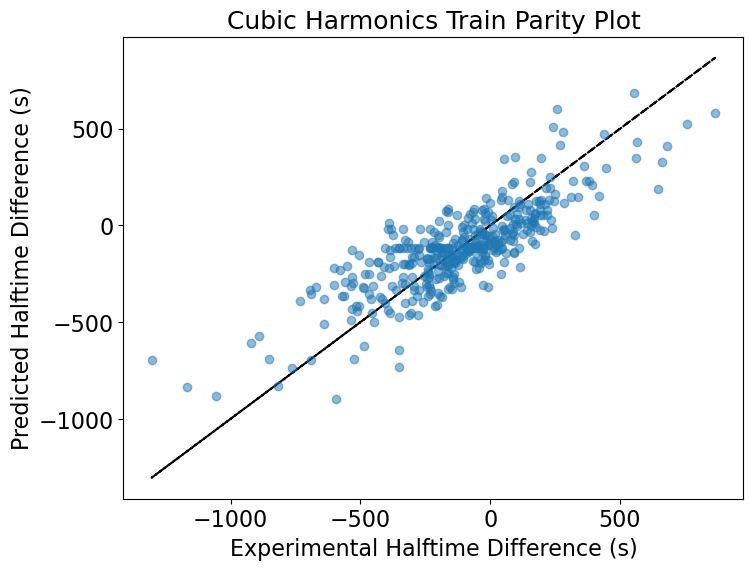

In [16]:
print("Mean Train error is", mean_absolute_error(y_train, clf.predict(X_train)), "sec")
print("Train R2 sccore", r2_score(y_train.reshape(-1,), clf.predict((X_train))))
plt.plot(y_train,y_train, 'k--',)#alpha = 0.8
plt.plot(y_train,clf.predict(X_train), "o",alpha = 0.5)
plt.title("Cubic Harmonics Train Parity Plot",fontsize = 18)
plt.xlabel("Experimental Halftime Difference (s)",fontsize = 16)
plt.ylabel("Predicted Halftime Difference (s)",fontsize = 16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# plt.xlim(-1000,1000)
# plt.ylim(-1000,1000)
plt.gcf().set_size_inches(8, 6)
plt.show()

Mean Train error is 131.3326255736742 sec
Test R2 sccore 0.7312214117446889


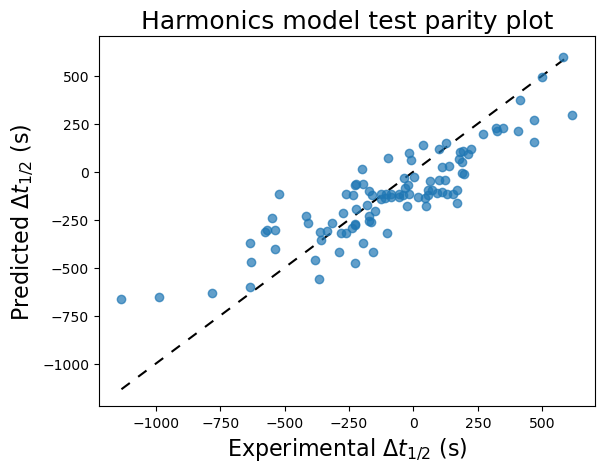

In [17]:
print("Mean Train error is",mean_absolute_error(y_test, clf.predict(X_test)), "sec")
print("Test R2 sccore", r2_score(y_test.reshape(-1,), clf.predict(X_test)))
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)],c = "k",linestyle='--', dashes=(5, 5))#alpha = 0.5
plt.plot(y_test,clf.predict(X_test), "o",alpha = 0.7)

plt.title("Harmonics model test parity plot",fontsize = 18)
plt.xlabel("Experimental $\Delta t_{1/2}$ (s)",fontsize = 16)
plt.ylabel("Predicted $\Delta t_{1/2}$ (s)",fontsize = 16)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
plt.show()

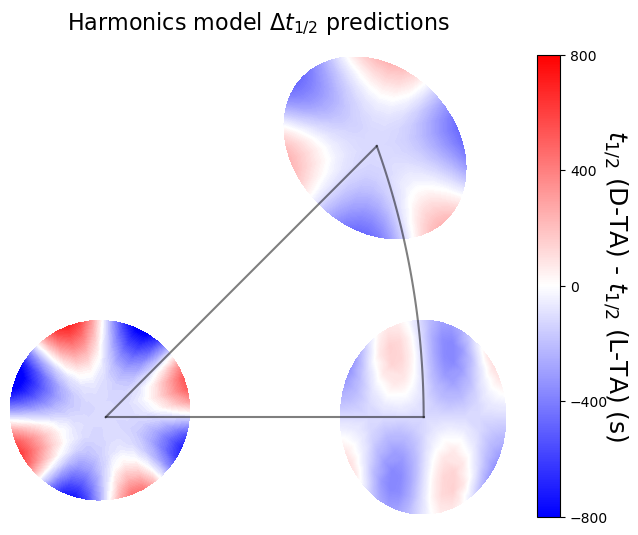

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(x_p_100, y_p_100,clf.predict(combined_harmonics(norm_miller_indices_100)).reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(x_p_110, y_p_110,clf.predict(combined_harmonics(norm_miller_indices_110)).reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(x_p_111, y_p_111,clf.predict(combined_harmonics(norm_miller_indices_111)).reshape(-1,),levels = 100,cmap='bwr', norm = norm)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-800, 800, 5))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)
#Draw the stereograhic triangle
x_values_1 = 0, 0.76235
y_values_1 =  0, 0
plt.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.65
y_values_2 =  0, 0.65
plt.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.65,  0.65]
point2 = [0, 0.76235]
y_1,x_1 = hanging_line(point1, point2)
plt.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)
ax.set_title("Harmonics model $\Delta t_{1/2}$ predictions", fontsize = 16, pad=20)
ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Extrapolate to the rest of the stereographic triangle

In [19]:
# the miller indices that could span the whole miller indices space
miller_indices = np.array(np.meshgrid(np.linspace(0,20,21), np.linspace(0,20,21), np.linspace(0,20,21))).T.reshape(-1,3)
miller_indices = miller_indices[1:,:]
miller_indices = miller_indices.astype('int64')
norm_miller_indices = miller_indices*np.repeat((1/np.linalg.norm(miller_indices, axis=1)).reshape(-1,1), 3, axis= 1)

In [20]:
xyz_100 = np.concatenate([norm_miller_indices[:,1].reshape(-1,1), norm_miller_indices[:,2].reshape(-1,1), norm_miller_indices[:,0].reshape(-1,1)], axis=1)
xyz_100f = xyz_100*np.repeat((1/np.linalg.norm(xyz_100, axis=1)).reshape(-1,1), 3, axis= 1)
xy_p = np.concatenate([(xyz_100f[:,0]/(1+xyz_100f[:,2])).reshape(-1,1), (xyz_100f[:,1]/(1+xyz_100f[:,2])).reshape(-1,1)], axis =1)

In [21]:
# select points within the stereographic triangle
idx = [np.where(((xy_p[:,1]**2+xy_p[:,0]**2)**0.5 <= 0.52) & (xy_p[:,0] <= -0.73*np.cosh(xy_p[:,1]) + 1.15))]
new_xy_p = xy_p[idx[0]]
new_miller_idx = norm_miller_indices[idx[0]]
new_idx = np.where(new_xy_p[:,1] <= new_xy_p[:,0])
new_xy_p = new_xy_p[new_idx[0]]
new_miller_idx = new_miller_idx[new_idx[0]]

In [22]:
harm = clf.predict(combined_harmonics(new_miller_idx))

In [23]:
np.max(harm), np.min(harm)

(1511.565364689967, -1121.8276183390185)

In [24]:
# Optimal surface:
print("Maximum surface", np.round(3*new_miller_idx[np.where(harm == np.max(harm))[0][0]]/ 0.14655959))

Maximum surface [19.  7.  3.]


In [25]:
np.max(harm)

1511.565364689967

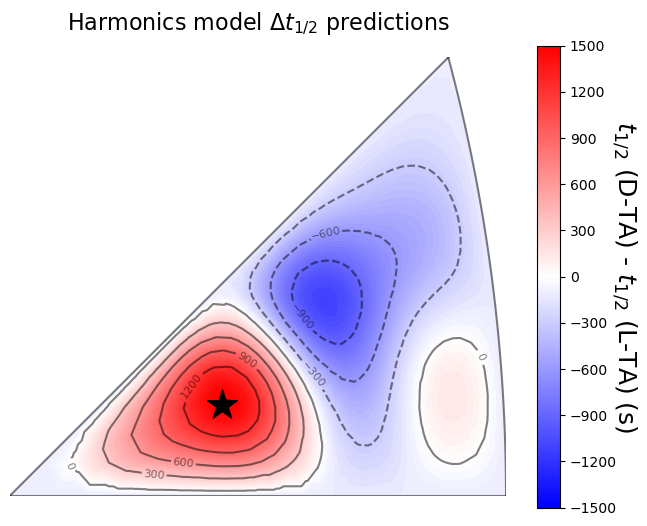

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = matplotlib.colors.Normalize(vmin=-1500, vmax=1500)
ax.tricontourf(new_xy_p[:,0], new_xy_p[:,1],harm.reshape(-1,),levels = 100,cmap='bwr', norm = norm)

# Add contour lines at constant values
contour_lines = plt.tricontour(new_xy_p[:,0], new_xy_p[:,1],harm.reshape(-1,), levels=np.linspace(-1500, 1500, 11), 
colors='k', alpha=0.5, norm=norm)

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-1500, 1500, 11))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)
#Draw the stereograhic triangle
x_values_1 = 0, 0.414214	
y_values_1 =  0, 0
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025	
y_values_2 =  0, 0.366025	
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025	, 0.366025]
point2 = [0, 0.414214	]
y_1,x_1 = hanging_line(point1, point2)
ax.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)
# highlight the optimal surface
ax.scatter(new_xy_p[:,0][np.where(harm == np.max(harm))[0][0]], 
        new_xy_p[:,1][np.where(harm == np.max(harm))[0][0]], c = 'k', s=500, edgecolors='black', marker ="*",alpha=1)

# highlight the GCN optimal surface 
# ax.scatter(0.13365694,0.04455231,c = 'g', s=500, edgecolors='black', marker ="*")

ax.set_title("Harmonics model $\Delta t_{1/2}$ predictions", fontsize = 16, pad=20)
ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

## Uncertainty in the data
### train 1000 models on different data splits and use their statistics to get uncertainity in the optimal value and the optimal location. 

In [ ]:
optimal_locations = []
optimal_value = []
sample_coef = []
for i in np.random.randint(50000000, size=1000):
    clf = Ridge(alpha=0.01, fit_intercept = True)
    x,y = combined_harmonics(combined_norm_miller_idx), combined_labels
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=i)
    # train the model
    clf.fit(X_train, y_train)
    sample_coef.append(clf.coef_[0])
    harm = clf.predict(combined_harmonics(new_miller_idx))
    optimal_locations.append(new_xy_p[np.where(harm == np.max(harm))[0][0]])
    optimal_value.append(np.max(harm))
    
optimal_locations = np.array(optimal_locations).reshape(-1,2) 
optimal_value = np.array(optimal_value)

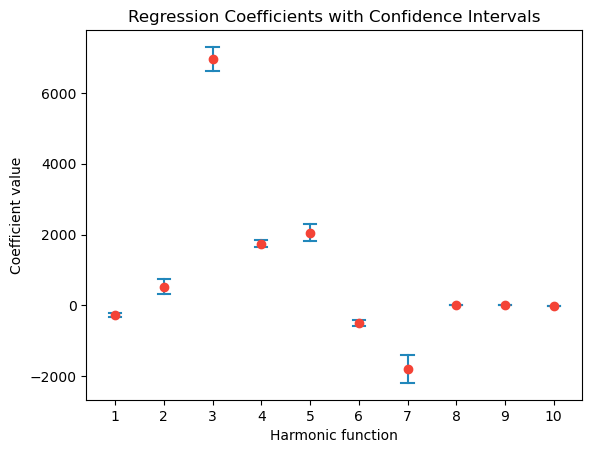

In [40]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8,9,10])

color = '#2187bb'
horizontal_line_width=0.25
left = x - horizontal_line_width / 2
right = x + horizontal_line_width / 2
top = np.mean(np.array(sample_coef), axis = 0) - np.std(np.array(sample_coef), axis = 0)
bottom = np.mean(np.array(sample_coef), axis = 0) + np.std(np.array(sample_coef), axis = 0)
plt.plot([x, x], [top, bottom], color=color)
plt.plot([left, right], [top, top], color=color)
plt.plot([left, right], [bottom, bottom], color=color)
plt.plot(x, np.mean(np.array(sample_coef), axis = 0), 'o', color='#f44336')
plt.title("Regression Coefficients with Confidence Intervals")
plt.xticks(np.array([1, 2, 3, 4, 5, 6, 7, 8,9,10]))
plt.ylabel("Coefficient value")
plt.xlabel("Harmonic function");

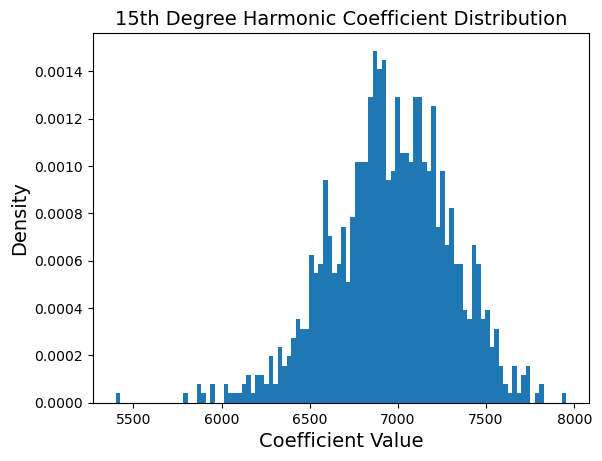

In [41]:
plt.hist(np.array(sample_coef)[:,2], density=True, bins=100)  
plt.xlabel("Coefficient Value", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.title("15th Degree Harmonic Coefficient Distribution", fontsize = 14)
plt.show()

In [42]:
count = []
unique_opts = []
mean_opt_value = []
std_opt_value = []
for j in np.unique(optimal_locations[:,0]):
    count.append(len(np.where(optimal_locations[:,0] == j)[0]))
    unique_opts.append(optimal_locations[np.where(optimal_locations[:,0] == j)[0][0]])
    mean_opt_value.append(np.mean(optimal_value[np.where(optimal_locations[:,0] == j)[0]]))
    std_opt_value.append(np.std(optimal_value[np.where(optimal_locations[:,0] == j)[0]]))
unique_opts = np.array(unique_opts)

In [43]:
harm = clf.predict(combined_harmonics(new_miller_idx))

### plot the location of the optimal surface where the size of the star reflects the frequency of this location was found to be optimal by the 1000 models 

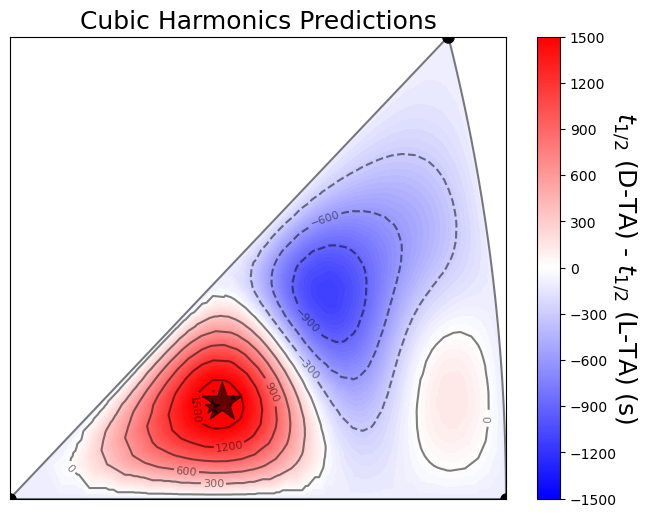

In [44]:
import matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
norm = matplotlib.colors.Normalize(vmin=-1500, vmax=1500)
ax.tricontourf(new_xy_p[:,0], new_xy_p[:,1],harm.reshape(-1,),levels = 100,cmap='bwr', norm = norm)

# Add contour lines at constant values
contour_lines = plt.tricontour(new_xy_p[:,0], new_xy_p[:,1],harm.reshape(-1,), levels=np.linspace(-1500, 1500, 11), 
colors='k', alpha=0.5, norm=norm)

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-1500, 1500, 11))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)
ax.scatter(unique_opts[:,0], unique_opts[:,1], c = "k", marker="*", s = np.array(count), alpha = 0.6 )

#Draw the stereograhic triangle
plt.plot(0, 0, 'k', marker="o", markersize=8, label = "(100)")
plt.plot(0.414214, 0, 'k', marker="o", markersize=8, label = "(110)")
plt.plot(0.366025, 0.366025, 'k', marker="o", markersize=8, label = "(111)")

x_values_1 = 0, 0.414214	
y_values_1 =  0, 0
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025	
y_values_2 =  0, 0.366025	
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025	, 0.366025]
point2 = [0, 0.414214	]
y_1,x_1 = hanging_line(point1, point2)
ax.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)
ax.set_title("Cubic Harmonics Predictions", fontsize = 18)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Maybe Supplementary information Figure
#### learning curve to determine the best number of cubic harmonics to use


Text(0.5, 0, 'Number of cubic harmonic functions')

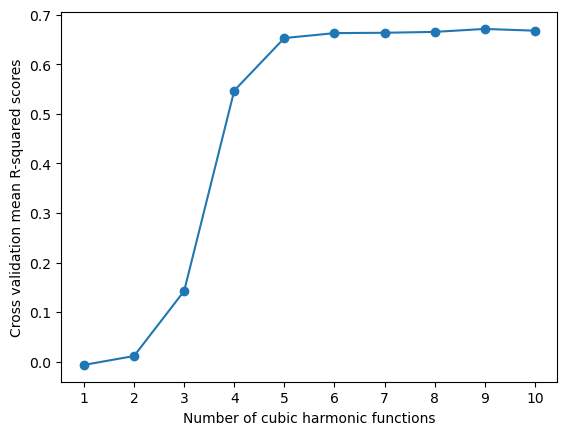

In [98]:
# start with the 9th degree cubic harmonic
clf = Ridge(alpha=0.01, fit_intercept = True)
cubic_harm_features = [cubic_harmonic(combined_norm_miller_idx[:,0], combined_norm_miller_idx[:,1], combined_norm_miller_idx[:,2], 9)]
x, y = np.array(cubic_harm_features).reshape(-1,1), combined_labels
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=1000)
scores = cross_val_score(clf, X_train, y_train, cv=5)
cross_val_scores = [np.mean(scores)]
for i in [15,13,17,19,21,23,25,27,29]:
    j = cubic_harmonic(combined_norm_miller_idx[:,0], combined_norm_miller_idx[:,1], combined_norm_miller_idx[:,2], i)
    cubic_harm_features.append(j)
    x, y = np.concatenate(np.array(cubic_harm_features), axis = 1), combined_labels
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=1000)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring ='r2')
    cross_val_scores.append(np.mean(scores))

plt.plot(np.linspace(1,10,10),cross_val_scores, "o-")
plt.xticks(np.array([1, 2, 3, 4, 5, 6, 7, 8,9,10]))
plt.ylabel("Cross validation mean R-squared scores")
plt.xlabel("Number of cubic harmonic functions");